In [1]:
import ehrapy as ep
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency

import warnings

warnings.filterwarnings("ignore")

/Users/eljasroellin/miniconda3/envs/bias_demonstration/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata = ep.dt.diabetes_130_fairlearn()
ep.ad.move_to_obs(adata, ["race", "gender", "age", "A1Cresult", "admission_source_id"], copy_obs=True)
adata.obs["A1Cresult_measured"] = ~adata.obs["A1Cresult"].isna()

❗ Features 'time_in_hospital', 'num_procedures', 'number_diagnoses', 'readmit_binary' were detected as categorical features stored numerically.Please verify and correct using `ep.ad.replace_feature_types` if necessary.
❗ Feature types were inferred and stored in adata.var[feature_type]. Please verify using `ep.ad.feature_type_overview` and adjust if necessary using `ep.ad.replace_feature_types`.


AnnData object with n_obs × n_vars = 101766 × 24
    obs: 'race', 'gender', 'age'
    var: 'feature_type'
    layers: 'original'

In [4]:
# pairwise chi-squared tests between the three groups
referral = adata.obs["A1Cresult_measured"][
    adata.obs["admission_source_id"] == "Referral"
]
emergency = adata.obs["A1Cresult_measured"][
    adata.obs["admission_source_id"] == "Emergency"
]
other = adata.obs["A1Cresult_measured"][adata.obs["admission_source_id"] == "Other"]

groups = [referral, emergency, other]
group_names = ["referral", "emergency", "other"]

# Perform pairwise comparisons
for i in range(len(groups)):
    for j in range(i + 1, len(groups)):
        # Create contingency table
        observed = [
            [sum(groups[i]), len(groups[i]) - sum(groups[i])],
            [sum(groups[j]), len(groups[j]) - sum(groups[j])],
        ]

        # Perform chi-squared test
        chi2, p, dof, expected = chi2_contingency(observed)

        # Print results
        print(f"Comparison between Group {group_names[i]} and Group {group_names[j]}:")
        print("Chi-squared statistic:", chi2)
        print("p-value:", p)
        print("Degrees of freedom:", dof)
        print("Expected frequencies:")
        print(expected)
        print()

Comparison between Group referral and Group emergency:
Chi-squared statistic: 596.215773821687
p-value: 1.1140447707715962e-131
Degrees of freedom: 1
Expected frequencies:
[[ 5390.28301075 25465.71698925]
 [10043.71698925 47450.28301075]]

Comparison between Group referral and Group other:
Chi-squared statistic: 16.380265752052786
p-value: 5.182197620427166e-05
Degrees of freedom: 1
Expected frequencies:
[[ 3944.81749187 26911.18250813]
 [ 1715.18250813 11700.81749187]]

Comparison between Group emergency and Group other:
Chi-squared statistic: 460.0554308187645
p-value: 4.6755054166738994e-102
Degrees of freedom: 1
Expected frequencies:
[[10493.40499224 47000.59500776]
 [ 2448.59500776 10967.40499224]]



All groupwise comparisons are significant at the 0.001% level (Bonferroni Correction threshold considered for three tests: 0.001/3=0.00033)

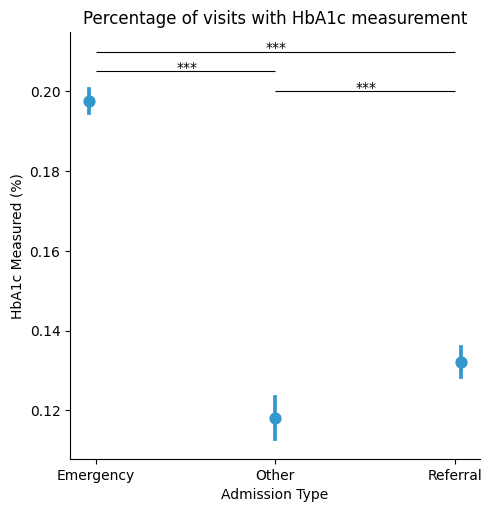

In [5]:
ep.pl.catplot(
    adata=adata,
    y="A1Cresult_measured",
    x="admission_source_id",
    kind="point",
    ci=95,
    dodge=True,
    join=False,
    palette=["#3399CC"],  # ehrapy palette
)
plt.xlabel("Admission Type")
plt.ylabel("HbA1c Measured (%)")
plt.title("Percentage of visits with HbA1c measurement")
plt.text(1.45, 0.2, "***")
plt.text(0.45, 0.205, "***")
plt.text(0.95, 0.21, "***")
plt.hlines(0.2, 1, 2, colors="black", linewidth=0.8)
plt.hlines(0.205, 0, 1, colors="black", linewidth=0.8)
plt.hlines(0.21, 0, 2, colors="black", linewidth=0.8)

plt.savefig("surveillance_bias.png", dpi=300, bbox_inches="tight")
plt.show()